# Cardiac Catheter Segmentation using U-Net Architecture 

#### Course Project by Muhammad Bin Sanaullah | Deep Learning in Medical Imaging (Spring 2022-23) | Bogazici University, Istanbul

In this project, a cardiac catheter is segmented using U-Net architecture from images taken from a radiograph video. The frames from the video are taken in MATLAB, each frame is then segmented using 3D Slicer software to create binary labelmap masks which act as true labels for the U-Net model to segment the catheter using deep learning. 

A data set of 234 images with label masks are used on a U-Net model with efficientnetb2 backbone with adam optimizer under 10 epochs to give an accurate segmented mask with good accuracy metrics. The code and results are explained as below.

In [1]:
import numpy as np 
import pandas as pd

In [2]:
import tensorflow as tf
import keras
import segmentation_models as sm
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Segmentation Models: using `keras` framework.


### Preprocessing 

The datasets are loaded into lists, separated into original x-ray images and their respective label masks obtained from 3D Slicer. The images are scaled and normalized onto a 256x256 size for more efficient computation. Then the data is divided into training and testing sets; 175 for training the model and 59 for testing it.

In [3]:
import glob
import cv2
images = glob.glob(r"C:\Users\muham\Desktop\MSc BME\Deep Learning in Medical Imaging\Cardiac Catheter Segmentation Project\images\*.jpg")
masks = glob.glob(r"C:\Users\muham\Desktop\MSc BME\Deep Learning in Medical Imaging\Cardiac Catheter Segmentation Project\masks\*.jpg")

In [4]:
# Load the images and masks into lists
image = []
mask = []
for x,y in zip(images,masks):
  im = cv2.imread(x,cv2.IMREAD_COLOR)
  im = cv2.resize(im,(256,256))
  im = im/255
  image.append(im)
  ma = cv2.imread(y,cv2.IMREAD_GRAYSCALE)
  ma = cv2.resize(ma,(256,256))
  ma = ma/255
  ma = np.expand_dims(ma,axis=-1)
  mask.append(ma)

In [5]:
print(len(image),len(mask))

234 234


In [6]:
img_array = np.array(image)
mask_array = np.array(mask)
mask_array = mask_array.astype(np.float32)
print(mask_array.shape)

(234, 256, 256, 1)


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(img_array,mask_array)
print(y_train.dtype,y_test.dtype)

float32 float32


### U-Net Model Training

The U-Net model is loaded from Keras and Tensorflow's own library with an 'efficientnetb2' backbone that serves in aided image classification in transfer learning where it provides the U-Net with pretrained weights (their repository manual: https://github.com/qubvel/segmentation_models).

The model is then compiled and trained for 10 epochs.

In [8]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.utils import plot_model

BACKBONE = 'efficientnetb2'

preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, encoder_weights = 'imagenet')


In [9]:
model.compile(optimizer = 'adam', loss = sm.losses.DiceLoss(), metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(),sm.metrics.iou_score,sm.metrics.FScore(threshold = 0.5)])

In [10]:
history = model.fit(x_train, y_train, batch_size = 1, epochs = 10, validation_data = (x_test,y_test))

Epoch 1/10
175/175 [==============================] - 51s 191ms/step - loss: 0.4181 - recall: 0.5529 - precision: 0.3832 - auc: 0.7787 - iou_score: 0.4675 - f1-score: 0.7040 - val_loss: 0.8994 - val_recall: 0.0168 - val_precision: 0.7028 - val_auc: 0.6586 - val_iou_score: 0.0534 - val_f1-score: 0.0741
Epoch 2/10
175/175 [==============================] - 30s 173ms/step - loss: 0.1667 - recall: 0.4147 - precision: 0.9945 - auc: 0.7578 - iou_score: 0.7145 - f1-score: 0.8415 - val_loss: 0.3427 - val_recall: 0.2409 - val_precision: 0.9657 - val_auc: 0.6930 - val_iou_score: 0.4903 - val_f1-score: 0.6708
Epoch 3/10
175/175 [==============================] - 30s 174ms/step - loss: 0.1593 - recall: 0.4116 - precision: 0.9950 - auc: 0.7461 - iou_score: 0.7253 - f1-score: 0.8453 - val_loss: 0.2218 - val_recall: 0.3504 - val_precision: 0.9225 - val_auc: 0.7286 - val_iou_score: 0.6378 - val_f1-score: 0.7859
Epoch 4/10
175/175 [==============================] - 31s 174ms/step - loss: 0.1582 - recal

### Testing the Trained Model

The trained model is then evaluated on different accuracy metrics. The most basic one starts with finding the precision, recall and F1 scores, to see that they are very good as seen below. 

In [11]:
model.evaluate(x_test,y_test)

2/2 [==============================] - 9s 3s/step - loss: 0.1604 - recall: 0.4193 - precision: 0.9921 - auc: 0.7333 - iou_score: 0.7234 - f1-score: 0.8408


[0.1603744924068451,
 0.41928204894065857,
 0.9921395778656006,
 0.733329176902771,
 0.723360538482666,
 0.8407883644104004]

In [12]:
test_preds = model.predict(x_test)
preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)

2/2 [==============================] - 3s 402ms/step


A sample output of the model can be seen in the images below, where the original input x-ray image, the ground true mask of the catheter and the predicted segmented mask of the catheter by the trained U-Net model are shown for comparison. It can be seen that the true and predicted masks are very much the same, no differences can be seen by the naked eye. This shows that our trained model has promising predictive accuracies. 

(-0.5, 255.5, 255.5, -0.5)

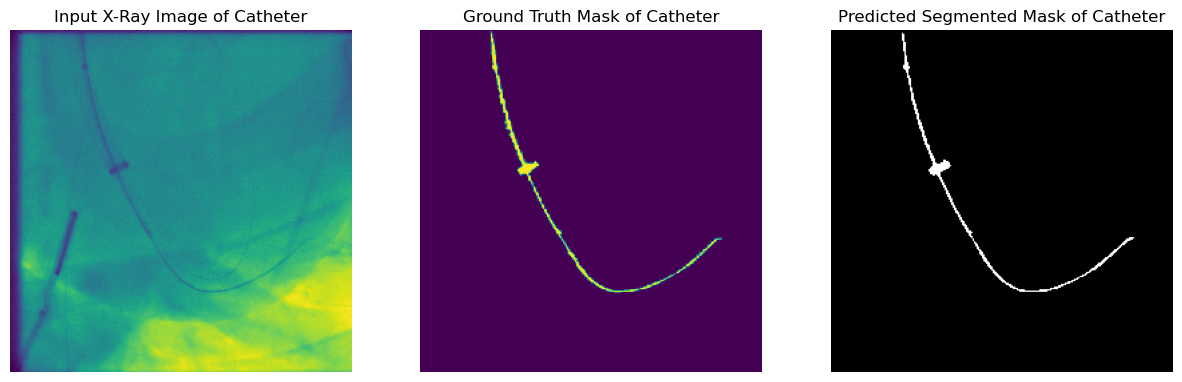

In [13]:
plt.figure(figsize = (15,15))
test_image = x_test[1, :, :, 0]
plt.subplot(1,3,1)
plt.imshow(test_image)
plt.title('Input X-Ray Image of Catheter')
plt.axis('off')

test_mask = y_test[1,:,:,0]
plt.subplot(1,3,2)
plt.imshow(test_mask)
plt.title('Ground Truth Mask of Catheter')
plt.axis('off')

test_mask = preds_test_thresh[1, :, :, 0]
#test_mask = test_preds[2, :, :, 0]
plt.subplot(1,3,3)
plt.imshow(test_mask, cmap='gray')
plt.title('Predicted Segmented Mask of Catheter')
plt.axis('off')

### Mean-Squared Error Analysis

MSE Analysis is a popular accuracy measure to see the average squared difference between the predicted and actual values. This is normally used in regression but MSE can also give some insight in image segmentation since the actual and predicted values constitute an array of binary values of the labelmap masks. The decreasing MSE values for more and more epochs shows promise of our model, that error decreased with more training.

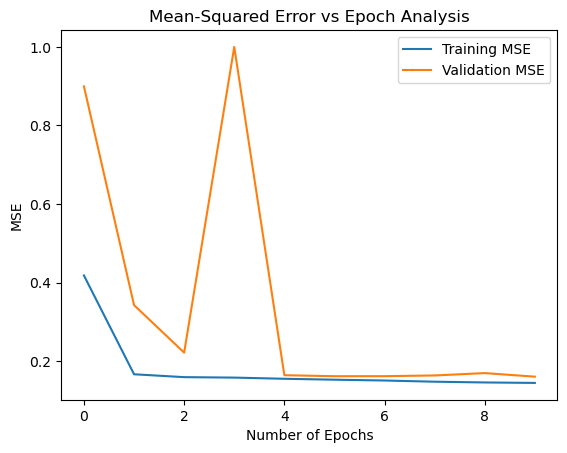

In [14]:
# Get the MSE and accuracy values
mse = np.array(history.history['loss'])
val_mse = np.array(history.history['val_loss'])
accuracy = 1 - mse
val_accuracy = 1 - val_mse

# Plot the MSE curve
plt.plot(mse, label = 'Training MSE')
plt.plot(val_mse, label = 'Validation MSE')
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
plt.title('Mean-Squared Error vs Epoch Analysis')
plt.legend()

### Accuracy Analysis

The most direct metric one can adopt is simply by analyzing accuracy changes along each epoch. We see below how the accuracy increases with each epoch, indicating promise of our model successfully segmenting the catheter.

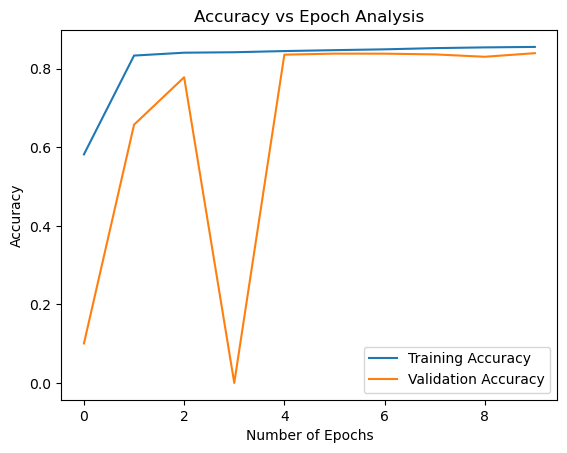

In [15]:
# Plot the accuracy curve
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch Analysis')
plt.legend()

### Jaccard Index Analysis

The Jaccard Index Analysis, or the Jaccard Similarity Coefficient Scores, involve IoU Scores which measure the overlap between the predicted and ground truth segmentation masks. These scores are computed as the intersection of the predicted and ground truth regions divided by the union of the two regions. This means that higher IoU values indicate better segmentation accuracy, with the range of these scores being 0-1: 0 meaning no intersection and 1 meaning full intersection. 

We see that for our model the average IoU Score is 0.42 i.e. 42% intersection overlap, which isn't great but it isn't bad either.

In [16]:
import numpy as np

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou


Average IoU Score: 0.4183617893657625


Text(0.5, 1.0, 'Jaccard Similarity Coefficient Measure')

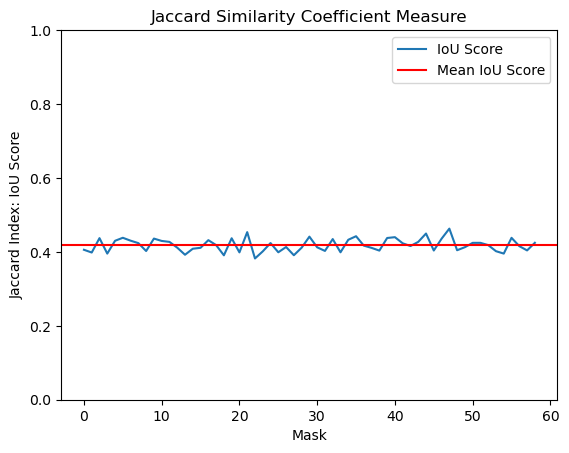

In [17]:
# Calculate IoU for each pair of masks
iou_scores = []
for i in range(len(y_test)):
    iou = calculate_iou(y_test[i,:,:,0], preds_test_thresh[i,:,:,0])
    iou_scores.append(iou)

# Compute average IoU across all masks
avg_iou = np.mean(iou_scores)

print(f"\nAverage IoU Score: {avg_iou}")

plt.plot(iou_scores, label = 'IoU Score')
plt.axhline(y = avg_iou, label = 'Mean IoU Score', color = 'r')
plt.ylim([0,1])
plt.legend()
plt.xlabel('Mask')
plt.ylabel('Jaccard Index: IoU Score')
plt.title('Jaccard Similarity Coefficient Measure')

### Pixel Accuracy Analysis

Pixel Accuracy measures the percentage of correctly classified pixels in the segmentation mask. It calculates the ratio of the number of correctly classified pixels to the total number of pixels in the image. Since it's a ratio of comparison, it'd range between 0-1 with 0 meaning no pixel correctly classified and 1 meaning all pixels correctly classified. 

For our model we see that the average pixel accuracy score is 0.97 i.e. 97% accurately classified pixels, which is a very good output and shows good promise of our model.

In [18]:
import numpy as np

def calculate_pixel_accuracy(y_true, y_pred):
    correct_pixels = np.sum(np.equal(y_true, y_pred))
    total_pixels = y_true.size
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy


Average Pixel Accuracy: 0.9741997153072034


Text(0.5, 1.0, 'Pixel Accuracy Comparison Analysis')

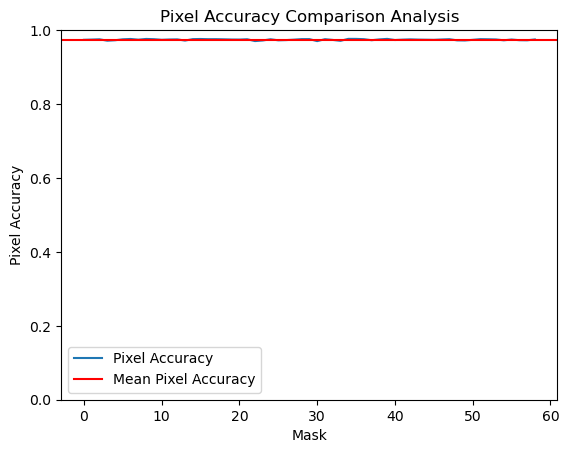

In [22]:
# Calculate Pixel Accuracy for each pair of masks
px_acc = []
for i in range(len(y_test)):
    pa = calculate_pixel_accuracy(y_test[i,:,:,0], preds_test_thresh[i,:,:,0])
    px_acc.append(pa)

# Compute average Pixel Accuracy across all masks
avg_pa = np.mean(px_acc)

print(f"\nAverage Pixel Accuracy: {avg_pa}")

plt.plot(px_acc, label = 'Pixel Accuracy')
plt.axhline(y = avg_pa, label = 'Mean Pixel Accuracy', color = 'r')
plt.ylim([0,1])
plt.legend()
plt.xlabel('Mask')
plt.ylabel('Pixel Accuracy')
plt.title('Pixel Accuracy Comparison Analysis')